# Image Denoising

We'll demonstrate the use of a typical encoder–decoder for denoising by denoising a very noisy brightfield image of a single particle.

## Simulate Data

We use `Deeptrack 2.0` to simulate a spherical particle.

In [8]:
import deeptrack as dt
import numpy as np

particle = dt.Sphere(
    position=np.array([0.5, 0.5]) * 64,
    z=0,
    position_unit="pixel",
    radius=50e-8,
    refractive_index=1.45 + 0.02j,
)

We define the optical sysetm to image the particle.

In [72]:
# illumination_gradient = dt.IlluminationGradient(
#     gradient=(0.01, 0.02),
#     constant=0.0,
# )

# aberr_coma = dt.HorizontalComa(
#     coefficient=1,
# )

spectrum = [500e-9]
brightfield_microscope = [
    dt.Brightfield(
        wavelength=wavelength,
        NA=1,
        resolution=1e-6,
        magnification=10,
        refractive_index_medium=1.33,
        upsample=2,
        output_region=(0, 0, 64, 64),
        # illumination=illumination_gradient,
        # pupil=aberr_coma,
    )
    for wavelength in spectrum
]

We simulate some noise

In [82]:
illuminated_sample = sum(
    [
        brightfield_microscope_onewl(particle)
        for brightfield_microscope_onewl in brightfield_microscope
    ]
)

noise = dt.Poisson(snr=lambda: 2.0 + np.random.rand() * 1)

label_of_particles = illuminated_sample >> dt.NormalizeMinMax()
image_of_particles = illuminated_sample >> noise >> dt.NormalizeMinMax()

In [83]:
from deeptrack.generators import ContinuousGenerator


class PyTorchContinuousGenerator(ContinuousGenerator):
    """Extends the ContinuousGenerator to support PyTorch models.

    This class is used to generate batches of data for PyTorch models."""

    def __init__(self, *args, flip=True, **kwargs):
        super().__init__(*args, **kwargs)
        self.flip = flip

    def __getitem__(self, idx):
        import torch

        X, y = super().__getitem__(idx)

        if self.flip:
            X = np.transpose(X, (0, 3, 1, 2)) if len(X.shape) == 4 else X
            y = np.transpose(y, (0, 3, 1, 2)) if len(y.shape) == 4 else y

        return torch.from_numpy(X).to(torch.float), torch.from_numpy(y).to(torch.float)

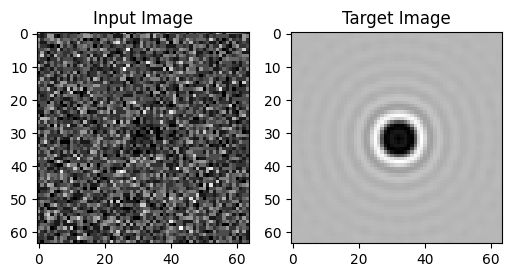

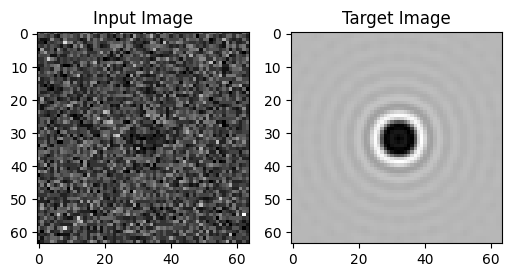

In [84]:
import matplotlib.pyplot as plt

for i in range(2):
    image_of_particles.update()
    label_of_particles.update()
    image = image_of_particles.resolve()
    label = label_of_particles.resolve()
    plt.figure(figsize=(6, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image[..., 0], cmap="gray")
    plt.title("Input Image")
    plt.subplot(1, 2, 2)
    plt.imshow(label[..., 0], cmap="gray")
    plt.title("Target Image")

In [85]:
generator = PyTorchContinuousGenerator(
    (image_of_particles) & (label_of_particles),
    batch_size=8,
    min_data_size=256,
    max_data_size=512,
)

In [87]:
import torch
from torch.nn import MaxPool2d, ReLU, Identity, Sigmoid, Upsample

encoder = dl.ConvolutionalNeuralNetwork(
    in_channels=1,
    hidden_channels=[64, 64],
    out_channels=64,
    pool=MaxPool2d(kernel_size=2),
    out_activation=ReLU,
)

bottleneck = dl.Layer(MaxPool2d, kernel_size=2)

decoder = dl.ConvolutionalNeuralNetwork(
    in_channels=64,
    hidden_channels=[64, 64],
    out_channels=1,
    pool=Upsample(scale_factor=2),
    out_activation=Sigmoid,
)
decoder.blocks[0].pool.configure(Upsample, scale_factor=2)
autoencoder = dl.Sequential(encoder, bottleneck, decoder)

print(autoencoder)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (1-2): 2 x PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
    )
  )
  (1): Layer[MaxPool2d](kernel_size=2)
  (2): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Upsample](scale_factor=2)
        (layer): Layer[Conv2d](in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
  

In [88]:
import torchmetrics as tm

regressor_template = dl.Regressor(
    model=autoencoder,
    loss=nn.L1Loss(),
    optimizer=dl.Adam(),
)

autoencoder_regressor = regressor_template.create()

In [89]:
autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")
with generator:
    autoencoder_trainer.fit(autoencoder_regressor, generator)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential       | 148 K 
5 | optimizer     | Adam             | 0     
---------------------------------------------------
148 K     Trainable params
0         Non-trainable params
148 K     Total params
0.596     Total estimated model params size (MB)


Generating 266 / 256 samples before starting training


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


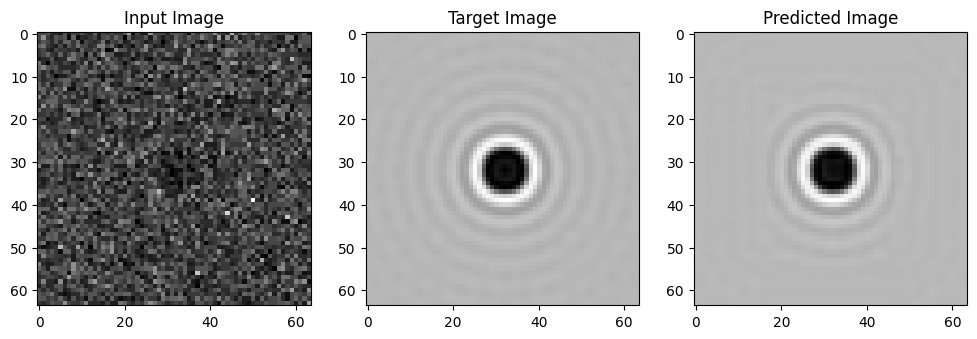

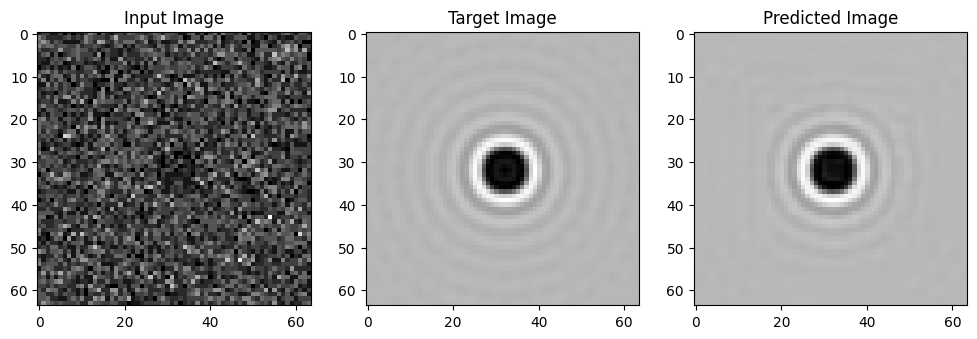

In [90]:
import matplotlib.pyplot as plt

input_im, target_im = generator[0]
predicted_im = autoencoder_regressor(input_im).detach()
for i in range(2):
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[i, 0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[i, 0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[i, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")

Text(0.5, 1.0, 'Predicted Image')

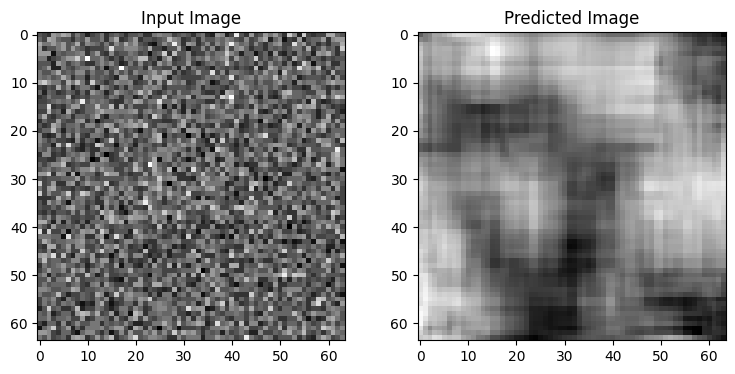

In [121]:
blank = sum(
    [
        brightfield_microscope_one_wl(particle ^ 0)
        for brightfield_microscope_one_wl in brightfield_microscope
    ]
)
blank_image = blank >> noise >> dt.NormalizeMinMax()
blank_image = blank_image.update().resolve().squeeze()
blank_image = torch.tensor(blank_image[np.newaxis, np.newaxis, :, :]).float()
predicted_image = autoencoder_regressor(blank_image).detach()
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(blank_image[0, 0, :, :], cmap="gray")
axs[0].set_title("Input Image")
axs[1].imshow(predicted_image[0, 0, :, :], cmap="gray")
axs[1].set_title("Predicted Image")

In [113]:
new_particle = dt.Sphere(
    position=lambda: np.array([0.4, 0.4] + np.random.rand(2) * 0.2) * 64,
    z=0,
    position_unit="pixel",
    radius=lambda: 50e-8 + np.random.rand() * 50e-8,
    refractive_index=1.45 + 0.02j,
)

In [114]:
new_illuminated_sample = sum(
    [
        brightfield_microscope_onewl(new_particle)
        for brightfield_microscope_onewl in brightfield_microscope
    ]
)

noise = dt.Poisson(snr=lambda: 2.0 + np.random.rand() * 1)

label_of_new_particles = new_illuminated_sample >> dt.NormalizeMinMax()
image_of_new_particles = new_illuminated_sample >> noise >> dt.NormalizeMinMax()

Generating 260 / 256 samples before starting training


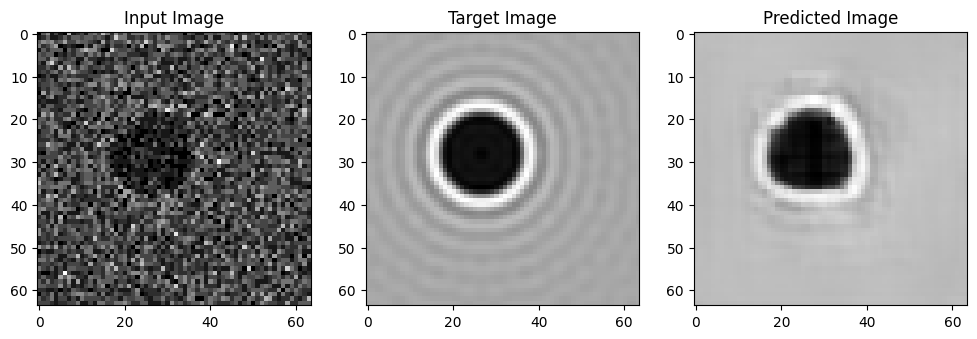

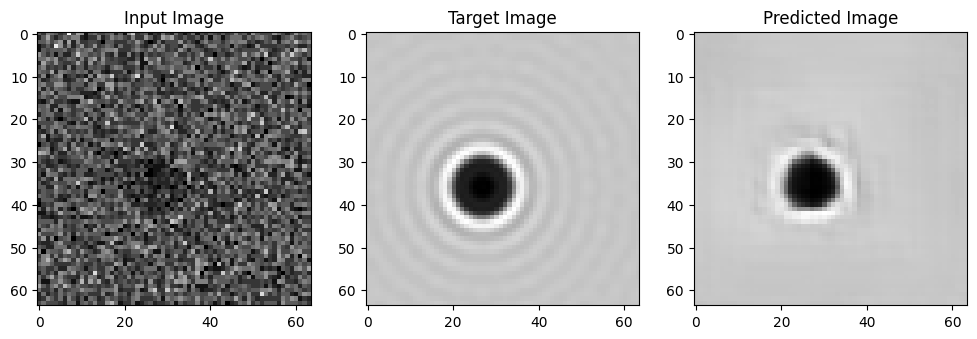

In [118]:
new_generator = PyTorchContinuousGenerator(
    (image_of_new_particles) & (label_of_new_particles),
    batch_size=8,
    min_data_size=256,
    max_data_size=512,
)

with new_generator:
    input_im, target_im = new_generator[0]
predicted_im = autoencoder_regressor(input_im).detach()
for i in range(2):
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[i, 0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[i, 0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[i, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")

In [119]:
autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")
with generator:
    autoencoder_trainer.fit(autoencoder_regressor, new_generator)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential       | 148 K 
5 | optimizer     | Adam             | 0     
---------------------------------------------------
148 K     Trainable params
0         Non-trainable params
148 K     Total params
0.596     Total estimated model params size (MB)


Generating 512 / 256 samples before starting training


/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


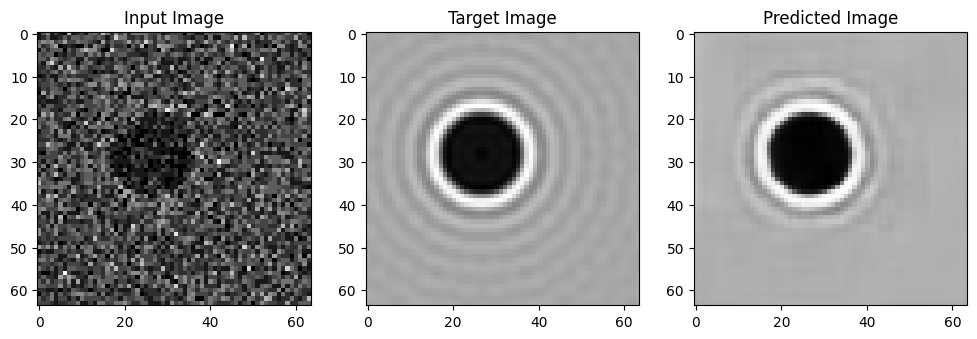

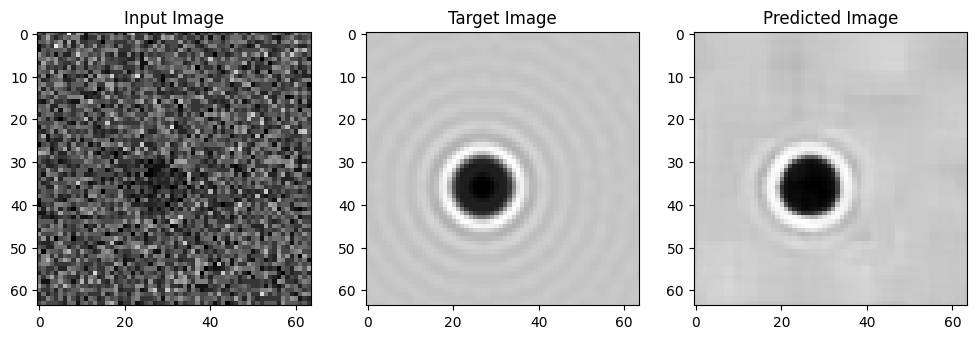

In [120]:
import matplotlib.pyplot as plt

input_im, target_im = new_generator[0]
predicted_im = autoencoder_regressor(input_im).detach()
for i in range(2):
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[i, 0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[i, 0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[i, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")

In [179]:
from typing import List, Optional, Literal, Any, Sequence, Type, overload, Union

# from ... import DeeplayModule, Layer, LayerList, PoolLayerActivationNormalization
from deeplay import DeeplayModule, Layer, LayerList, PoolLayerActivationNormalization
import torch.nn as nn


class EncoderDecoder(DeeplayModule):
    """Convolutional Neural Network (CNN) module.

    Parameters
    ----------
    in_channels: int or None
        Number of input features. If None, the input shape is inferred from the first forward pass
    hidden_channels: list[int]
        Number of hidden units in each layer
    out_channels: int
        Number of output features
    out_activation: template-like
        Specification for the output activation of the MLP. (Default: nn.Identity)
    pool: template-like
        Specification for the pooling of the block. Is not applied to the first block. (Default: nn.Identity)


    Parameters
    ----------
    in_channels: int or None
        Number of input features. If None, the input shape is inferred from the first forward pass
    hidden_channels: list[int]
        Number of hidden units in each layer
    out_channels: int
        Number of output features
    out_activation: template-like
        Specification for the output activation of the MLP. (Default: nn.Identity)
    pool: template-like
        Specification for the pooling of the block. Is not applied to the first block. (Default: nn.Identity)


    Configurables
    -------------
    - in_channels (int): Number of input features. If None, the input shape is inferred from the first forward pass.
    - hidden_channels (list[int]): Number of hidden units in each layer.
    - out_channels (int): Number of output features.
    - blocks (template-like): Specification for the blocks of the CNN. (Default: "layer" >> "activation" >> "normalization" >> "dropout")
        - pool (template-like): Specification for the pooling of the block. (Default: nn.Identity)
        - layer (template-like): Specification for the layer of the block. (Default: nn.Linear)
        - activation (template-like): Specification for the activation of the block. (Default: nn.ReLU)
        - normalization (template-like): Specification for the normalization of the block. (Default: nn.Identity)
        - dropout (template-like): Specification for the dropout of the block. (Default: nn.Identity)
    - out_activation (template-like): Specification for the output activation of the MLP. (Default: nn.Identity)

    Constraints
    -----------
    - input shape: (batch_size, ch_in)
    - output shape: (batch_size, ch_out)

    Evaluation
    ----------
    >>> for block in mlp.blocks:
    >>>    x = block(x)
    >>> return x

    Examples
    --------
    >>> # Using default values
    >>> cnn = ConvolutionalNeuralNetwork(3, [32, 64, 128], 1)
    >>> # Customizing output activation
    >>> cnn.output_block.activation(nn.Sigmoid)
    >>> # Changing the kernel size of the first layer
    >>> cnn.input_block.layer.kernel_size(5)


    Return Values
    -------------
    The forward method returns the processed tensor.

    Additional Notes
    ----------------
    The `Config` and `Layer` classes are used for configuring the blocks of the MLP. For more details refer to [Config Documentation](#) and [Layer Documentation](#).

    """

    in_channels: Optional[int]
    encoder_channels: Sequence[Optional[int]]
    decoder_channels: Sequence[Optional[int]]
    out_channels: int
    blocks: LayerList[PoolLayerActivationNormalization]

    @property
    def input(self):
        """Return the input layer of the network. Equivalent to `.blocks[0]`."""
        return self.blocks[0]

    @property
    def hidden(self):
        """Return the hidden layers of the network. Equivalent to `.blocks[:-1]`"""
        return self.blocks[:-1]

    @property
    def output(self):
        """Return the last layer of the network. Equivalent to `.blocks[-1]`."""
        return self.blocks[-1]

    @property
    def layer(self) -> LayerList[Layer]:
        """Return the layers of the network. Equivalent to `.blocks.layer`."""
        return self.blocks.layer

    @property
    def activation(self) -> LayerList[Layer]:
        """Return the activations of the network. Equivalent to `.blocks.activation`."""
        return self.blocks.activation

    @property
    def normalization(self) -> LayerList[Layer]:
        """Return the normalizations of the network. Equivalent to `.blocks.normalization`."""
        return self.blocks.normalization

    def __init__(
        self,
        in_channels: Optional[int],
        encoder_channels: Sequence[int],
        decoder_channels: Sequence[int],
        out_channels: int,
        out_activation: Union[Type[nn.Module], nn.Module, None] = None,
        pool: Union[Type[nn.Module], nn.Module, None] = None,
        unpool: Union[Type[nn.Module], nn.Module, None] = None,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.encoder_channels = encoder_channels
        self.decoder_channels = decoder_channels
        self.out_channels = out_channels
        self.hidden_channels = encoder_channels + decoder_channels

        if out_channels <= 0:
            raise ValueError(f"out_channels must be positive, got {out_channels}")

        if in_channels is not None and in_channels <= 0:
            raise ValueError(f"in_channels must be positive, got {in_channels}")

        if any(h <= 0 for h in self.hidden_channels):
            raise ValueError(
                f"all hidden_channels must be positive, got {self.hidden_channels}"
            )

        if out_activation is None:
            out_activation = Layer(nn.Identity)
        elif isinstance(out_activation, type) and issubclass(out_activation, nn.Module):
            out_activation = Layer(out_activation)

        self.blocks = LayerList()

        c_out = in_channels

        for i, c_out in enumerate(self.encoder_channels + [self.encoder_channels[-1]]):
            c_in = self.in_channels if i == 0 else self.encoder_channels[i - 1]

            if i == 0:
                pool_layer = Layer(nn.Identity)
            else:
                if pool is None:
                    pool_layer = Layer(nn.MaxPool2d, kernel_size=2)
                elif isinstance(pool, type) and issubclass(pool, nn.Module):
                    pool_layer = Layer(pool)
                elif isinstance(pool, DeeplayModule):
                    pool_layer = pool.new()
                else:
                    pool_layer = pool

            if i < len(self.encoder_channels):
                if c_in:
                    layer = Layer(nn.Conv2d, c_in, c_out, 3, 1, 1)
                else:
                    layer = Layer(nn.LazyConv2d, c_out, 3, 1, 1)
            else:
                layer = Layer(nn.Identity, num_features=c_out)

            activation = (
                Layer(nn.ReLU)
                if i < len(self.encoder_channels)
                else Layer(nn.Identity, num_features=c_out)
            )
            normalization = Layer(nn.Identity, num_features=c_out)

            block = PoolLayerActivationNormalization(
                pool=pool_layer,
                layer=layer,
                activation=activation,
                normalization=normalization,
            )

            self.blocks.append(block)

        c_in = c_out
        for i, c_out in enumerate(self.decoder_channels + [out_channels]):
            c_in = c_in if i == 0 else self.decoder_channels[i - 1]

            if unpool is None:
                unpool_layer = (
                    Layer(nn.ConvTranspose2d, c_in, c_in, 3, 1, 1)
                    # if c_in
                    # else Layer(nn.LazyConvTranspose2d, c_out, 3, 1, 1)
                )
                # unpool_layer = Layer(nn.Upsample, scale_factor=2)
            elif isinstance(unpool, type) and issubclass(unpool, nn.Module):
                unpool_layer = Layer(unpool)
            elif isinstance(unpool, DeeplayModule):
                unpool_layer = unpool.new()
            else:
                unpool_layer = unpool

            layer = (
                Layer(nn.Conv2d, c_in, c_out, 3, 1, 1)
                if c_in
                else Layer(nn.LazyConv2d, c_out, 3, 1, 1)
            )
            activation = (
                Layer(nn.ReLU) if i < len(self.decoder_channels) else out_activation
            )
            normalization = Layer(nn.Identity, num_features=out_channels)

            block = PoolLayerActivationNormalization(
                pool=unpool_layer,
                layer=layer,
                activation=activation,
                normalization=normalization,
            )

            self.blocks.append(block)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

    @overload
    def configure(
        self,
        /,
        in_channels: Optional[int] = None,
        encoder_channels: Optional[List[int]] = None,
        decoder_channels: Optional[List[int]] = None,
        out_channels: Optional[int] = None,
        out_activation: Union[Type[nn.Module], nn.Module, None] = None,
    ) -> None:
        ...

    @overload
    def configure(
        self,
        name: Literal["blocks"],
        order: Optional[Sequence[str]] = None,
        layer: Optional[Type[nn.Module]] = None,
        activation: Optional[Type[nn.Module]] = None,
        normalization: Optional[Type[nn.Module]] = None,
        **kwargs: Any,
    ) -> None:
        ...

    @overload
    def configure(
        self,
        name: Literal["blocks"],
        index: Union[int, slice, List[Union[int, slice]]],
        order: Optional[Sequence[str]] = None,
        layer: Optional[Type[nn.Module]] = None,
        activation: Optional[Type[nn.Module]] = None,
        normalization: Optional[Type[nn.Module]] = None,
        **kwargs: Any,
    ) -> None:
        ...

    configure = DeeplayModule.configure

In [180]:
autoenc = EncoderDecoder(
    in_channels=1,
    encoder_channels=[16, 32, 64],
    decoder_channels=[32, 16],
    out_channels=1,
    # pool=MaxPool2d(kernel_size=2),
    # unpool=LazyConvTranspose2d,
    out_activation=Sigmoid,
)

print(autoenc)

EncoderDecoder(
  (blocks): LayerList(
    (0): PoolLayerActivationNormalization(
      (pool): Layer[Identity]()
      (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=16)
    )
    (1): PoolLayerActivationNormalization(
      (pool): Layer[MaxPool2d](kernel_size=2)
      (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=32)
    )
    (2): PoolLayerActivationNormalization(
      (pool): Layer[MaxPool2d](kernel_size=2)
      (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=64)
    )
    (3): PoolLayerActivationNormalization(
      (pool): Layer[MaxPool2d](kernel_size=2)
      (layer): Layer[Identity](num_fea

In [181]:
regressor_template = dl.Regressor(
    model=autoenc,
    loss=nn.L1Loss(),
    optimizer=dl.Adam(),
)

autoenc_regressor = regressor_template.create()

In [182]:
autoenc_trainer = dl.Trainer(max_epochs=150, accelerator="auto")
with new_generator:
    autoenc_trainer.fit(autoenc_regressor, new_generator)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | EncoderDecoder   | 69.8 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
69.8 K    Trainable params
0         Non-trainable params
69.8 K    Total params
0.279     Total estimated model params size (MB)


Generating 264 / 256 samples before starting training


Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [32, 64, 3, 3], expected input[8, 32, 8, 8] to have 64 channels, but got 32 channels instead

In [124]:
from typing import Optional, Sequence

# from ..application import Application
# from ...external import External, Optimizer, Adam
from deeplay.applications.application import Application
from deeplay.external import External, Optimizer, Adam

import torch
import torch.nn.functional as F
import torchmetrics as tm


class EncoderDecoder(Application):
    model: torch.nn.Module
    loss: torch.nn.Module
    metrics: list
    optimizer: Optimizer

    def __init__(
        self,
        model: torch.nn.Module,
        loss: torch.nn.Module = torch.nn.L1Loss(),
        optimizer=None,
        **kwargs,
    ):
        super().__init__(loss=loss, **kwargs)

        self.model = model
        self.optimizer = optimizer or Adam(lr=1e-3)

        @self.optimizer.params
        def params():
            return self.model.parameters()

    def configure_optimizers(self):
        return self.optimizer

    def forward(self, x):
        return self.model(x)